In [2]:
##!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Last Modified: Tuesday Nov 16, 2021
@author: sarahzeichner

Model to approximate peaks and understand cutoff differences in ratios

"""

'\nLast Modified: Tuesday Nov 16, 2021\n@author: sarahzeichner\n\nModel to approximate peaks and understand cutoff differences in ratios\n\n'

In [3]:
import numpy as np
from scipy import stats
from decimal import *
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

Define gaussian to be able to make fake peaks

In [4]:
def gaussian(x,a,x0,sigma,c):
    return a*np.exp(-(x-x0)**2/((2*sigma)**2))+c

Test the gaussian function with different parameters to choose parameters (defined above) to loop through

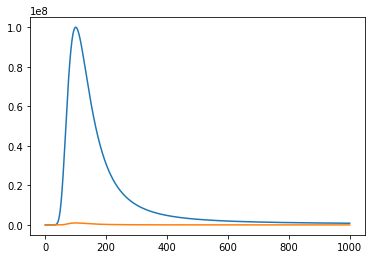

In [5]:
#test and plot gaussian to see how it affects different parameters
time = np.arange(0.001,1000,0.2)
time_mean = np.average(time)

norm_dist = gaussian(time,1e8,100,6+0.2*time,0)
norm_dist_2 = gaussian(time,1e6,100.1,2+0.2*time,0)
plt.plot(time,norm_dist)
plt.plot(time,norm_dist_2)
plt.show()

Set up parameters to model the peaks

In [6]:
time_start = 0.001
time_stop = 1000
time_step = 0.001
CN = 4.4 #scaling factor to convert NL scores to counts, from Eiler et al 2017

#properties of orbitrap measurement
scanLength = .3 #300 ms scan for 120k resolution
AGC_target = 2E5 #2e5 agc target
resolution = 120000 #resolution used for the experiment
maxITTime = 3 #3000ms max IT

#properties of the peak
M_mean = 100 
peakOffsetInTime = np.arange(0,0.15,0.01) #50-150ms offset for 13C based on Ricci data
M_sigma = np.arange(1,6,1) #Use the same sigma for both fragments to assume that they are eluting for the same time period
M_skew = np.arange(0.1,0.25,0.025)
M_ampl_NL = 1E8
Mplus1_relativeAbundance = .01 #set to roughly natural abundance of 13C/12C
M_ampl = M_ampl_NL * CN *np.power((120000/resolution),0.5) #Convert to counts
Mplus1_ampl = M_ampl * Mplus1_relativeAbundance #Calculate maximum height of substituted peak based on given relative abundance
M_background = M_ampl/1000 #background is roughly 1E5 for 1E8 intensity (assuming 1% height of peaks)
Mplus1_background = Mplus1_ampl/1000

# properties of data processing
scanCull = np.arange(0,0.2,0.025) #Cull scan height between 10 and 20% of maximum peak height

# Return variable arrays
unculled_ratio_array = []
culled_ratio_array = []
ratio_diff_array = []
peak_offset_array = []
sigma_array = []
scan_cull_array = []
skew_array = []
amount_culled_array = []

Loop through the defined parameters for the model

In [81]:
for i in peakOffsetInTime:
    for j in M_sigma:
        for k in M_skew:
                for l in scanCull:
                    #Compute offset of M_plus1 peak
                    Mplus1_mean = M_mean + i
                                    
                    #Calculate an array based on scan times
                    time_array = np.arange(time_start, time_stop, time_step)

                    sigma = j + (k*time_array)
                    M_array = gaussian(time_array,M_ampl,M_mean,sigma,M_background)
                    Mplus1_array = gaussian(time_array,Mplus1_ampl,Mplus1_mean,sigma,Mplus1_background)

                    #Calculate a ratio for each of the arrays for the original ratio
                    unculled_M_sum = np.sum(M_array)
                    unculled_Mplus1_sum = np.sum(Mplus1_array)
                    unculled_ratio = (unculled_Mplus1_sum)/(unculled_M_sum)
                    unculled_ratio_array.append(unculled_ratio)

                    #Cull based on input fragment height parameters
                    cullThreshold = l * M_ampl
                    time_cull_indices = np.where(M_array < cullThreshold)

                    #set up indexer for looping through ctrap and orbitrap filling
                    orbitrap_measurement_time_indexer = np.zeros(len(time_array))
                    measurement_end_index = len(time_array) -1

                    #Set up time points for Ctrap and Orbitrap filling
                    agc_fill_index = 0
                    agc_fill_start = time_array[agc_fill_index]
                    itTimeCurrentScan = 0.3
                    agc_fill_stop = agc_fill_start + itTimeCurrentScan
                    agc_stop_index = agc_fill_index + int((agc_fill_stop - agc_fill_start)/time_step)
                    scan_start_time = agc_fill_stop
                    scan_start_index = agc_stop_index
                    scan_stop_time = round(scan_start_time + scanLength,3) #time step to determine when scan stops
                    scan_stop_index = scan_start_index + int((scan_stop_time - scan_start_time)/time_step)
                    
                    cTrapIonSum = 0.001
                    itTimeSum = 0

                    #Loop through and process which scans are seen and which are not
                    while agc_fill_index < measurement_end_index:
                        #Set up indices for agc and scan length
                        current_agc_fill_time = time_array[agc_fill_index]
                        
                        #indicate use of current step in culled ratio calculation
                        orbitrap_measurement_time_indexer[agc_fill_index] = 1
                        #add ions to the ctrap for the current time step
                        cTrapIonSum = cTrapIonSum + (M_array[agc_fill_index] + Mplus1_array[agc_fill_index])*time_step

                        #check to see if the ctrap is full
                        if current_agc_fill_time >= agc_fill_stop: #Ctrap meets the agc target, so wait until the next scan starts 
                            if scan_stop_index < measurement_end_index: #check to make sure the next scan doesn't start beyond the peak tail
                                scan_start_index = scan_stop_index #set the scan start to the end of the last scan
                                itTimeCurrentScan = np.divide(itTimeCurrentScan,cTrapIonSum) * AGC_target #recalculate the IT time for the next scan based on ion fluence of current scan

                                #handle for different cases of how long the IT time is
                                if itTimeCurrentScan > maxITTime:
                                    itTimeCurrentScan = maxITTime
                                    agc_fill_index = scan_start_index
                                elif itTimeCurrentScan >= scanLength:
                                    agc_fill_index = scan_start_index
                                else:
                                    agc_fill_index = scan_start_index + int((scan_stop_time - itTimeCurrentScan)/time_step) #set the agc to start filling before the end of the scan, by the precalculated IT time from the current scan

                                #reset time start and stop indices, clear the ctrap
                                if agc_fill_index < measurement_end_index:
                                    agc_fill_start = time_array[agc_fill_index]
                                    agc_fill_stop = agc_fill_start + itTimeCurrentScan
                                    agc_stop_index = agc_fill_index + int((agc_fill_stop - agc_fill_start)/time_step)

                                    if agc_stop_index < measurement_end_index:
                                        scan_start_time = agc_fill_stop
                                        scan_start_index = agc_stop_index
                                        scan_stop_time = round(scan_start_time + scanLength,3) #time step to determine when scan stops
                                        scan_stop_index = scan_start_index + int((scan_stop_time - scan_start_time)/time_step)
                                        cTrapIonSum = 0.001 #clear the Ctrap , but set to a non zero value so it does not error out as nan
                                    else:
                                        #print("index ending #:" + str(scan_start_index) +"; next fill stop index is bigger than the length of the time array")
                                        break
                                else:
                                    #print("index ending #:" + str(scan_start_index) +"; next fill start index is bigger than the length of the time array")
                                    break
                            else:
                                #print("index ending #:" + str(scan_start_index) +"; agc end index is bigger than the length of the time array")
                                break
                        else: #continue filling the ctrap with the next scan
                            agc_fill_index = agc_fill_index + 1

                    #Cull based on input fragment height parameters and orbitrap time binning
                    cull_indices = np.where(orbitrap_measurement_time_indexer == 0)

                    #cull out scans that don't count
                    M_array[time_cull_indices] = 0
                    Mplus1_array[time_cull_indices] = 0
                    M_array[cull_indices] = 0
                    Mplus1_array[cull_indices] = 0
                
                    #Calculate ratio for culled scans
                    culled_M_sum = np.sum(M_array)
                    culled_Mplus1_sum = np.sum(Mplus1_array)
                    culled_ratio = (culled_Mplus1_sum)/(culled_M_sum)
                    culled_ratio_array.append(culled_ratio)

                    #Compute difference between culled and unculled
                    ratio_diff = ((culled_ratio - unculled_ratio)/unculled_ratio) *1000
                    amount_culled = culled_M_sum / unculled_M_sum

                    #add ratio diff to array for looping
                    ratio_diff_array.append(ratio_diff)
                    peak_offset_array.append(i)
                    sigma_array.append(j)
                    scan_cull_array.append(l)
                    skew_array.append(k)
                    amount_culled_array.append(amount_culled)

                    time_array = []

Print the average and standard deviation for the model runs

In [82]:
print("average error:" + str(np.average(np.absolute(ratio_diff_array))))
print("stdev error:" + str(np.std((np.absolute(ratio_diff_array)))))


average error:1.8643829035627217
stdev error:1.6458605729806564


Plot and output the results to a csv

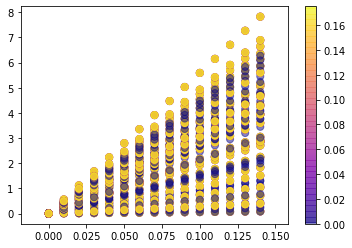

In [83]:
#create scatterplot
hfont = {'fontname':'Helvetica'}
plt.scatter(peak_offset_array, np.absolute(ratio_diff_array), s=50, c=scan_cull_array, cmap="plasma", alpha=0.5)
plt.draw()
plt.colorbar()
plt.rc(hfont)
plt.savefig("/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/drafts/figures/modelIterations.svg", format="svg")
plt.show()

In [84]:
df = pd.DataFrame({ "peak offset" : peak_offset_array, \
                    "sigma" : sigma_array, 
                    "scan cull" : scan_cull_array, \
                    "skew" : skew_array, \
                    "unculled ratio" : unculled_ratio_array, \
                    "culled ratio" : culled_ratio_array, \
                    "original peak amt culled": amount_culled_array,\
                    "error" : np.absolute(ratio_diff_array)   })
df.to_csv("peakModelOutput_WithOrbitrapCTrapBinning_testShortPeak.csv", index=False)

Now, we will model sample standard comparison to see how much changes in this affects the results

In [7]:
'''
This function performs all the logic of the above loop, but nested in a function so it can be used
for sample standard comparison.
'''
def modelPeakRatios(M_ampl, Mplus1_ampl, M_mean, peakOffsetInTime,\
                    M_sigma, M_skew, M_background, Mplus1_background,\
                    time_start,time_stop, time_step, scanCull):


    #Compute offset of M_plus1 peak
    Mplus1_mean = M_mean + peakOffsetInTime
                    
    #Calculate an array based on scan times
    time_array = np.arange(time_start, time_stop, time_step)

    sigma = M_sigma + (M_skew*time_array)
    M_array = gaussian(time_array,M_ampl,M_mean,sigma,M_background)
    Mplus1_array = gaussian(time_array,Mplus1_ampl,Mplus1_mean,sigma,Mplus1_background)

    #Calculate a ratio for each of the arrays for the original ratio
    unculled_M_sum = np.sum(M_array)
    unculled_Mplus1_sum = np.sum(Mplus1_array)
    unculled_ratio = (unculled_Mplus1_sum)/(unculled_M_sum)

    #Cull based on input fragment height parameters
    cullThreshold = scanCull * M_ampl
    time_cull_indices = np.where(M_array < cullThreshold)

    #set up indexer for looping through ctrap and orbitrap filling
    orbitrap_measurement_time_indexer = np.zeros(len(time_array))
    measurement_end_index = len(time_array) -1

    #Set up time points for Ctrap and Orbitrap filling
    agc_fill_index = 0
    agc_fill_start = time_array[agc_fill_index]
    itTimeCurrentScan = 0.3
    agc_fill_stop = agc_fill_start + itTimeCurrentScan
    agc_stop_index = agc_fill_index + int((agc_fill_stop - agc_fill_start)/time_step)
    scan_start_time = agc_fill_stop
    scan_start_index = agc_stop_index
    scan_stop_time = round(scan_start_time + scanLength,3) #time step to determine when scan stops
    scan_stop_index = scan_start_index + int((scan_stop_time - scan_start_time)/time_step)
    
    cTrapIonSum = 0.001

    #Loop through and process which scans are seen and which are not
    while agc_fill_index < measurement_end_index:
        #Set up indices for agc and scan length
        current_agc_fill_time = time_array[agc_fill_index]
        
        #indicate use of current step in culled ratio calculation
        orbitrap_measurement_time_indexer[agc_fill_index] = 1
        #add ions to the ctrap for the current time step
        cTrapIonSum = cTrapIonSum + (M_array[agc_fill_index] + Mplus1_array[agc_fill_index])*time_step

        #check to see if the ctrap is full
        if current_agc_fill_time >= agc_fill_stop: #Ctrap meets the agc target, so wait until the next scan starts 
            if scan_stop_index < measurement_end_index: #check to make sure the next scan doesn't start beyond the peak tail
                scan_start_index = scan_stop_index #set the scan start to the end of the last scan
                itTimeCurrentScan = np.divide(itTimeCurrentScan,cTrapIonSum) * AGC_target #recalculate the IT time for the next scan based on ion fluence of current scan

                #handle for different cases of how long the IT time is
                if itTimeCurrentScan > maxITTime:
                    itTimeCurrentScan = maxITTime
                    agc_fill_index = scan_start_index
                elif itTimeCurrentScan >= scanLength:
                    agc_fill_index = scan_start_index
                else:
                    agc_fill_index = scan_start_index + int((scan_stop_time - itTimeCurrentScan)/time_step) #set the agc to start filling before the end of the scan, by the precalculated IT time from the current scan

                #reset time start and stop indices, clear the ctrap
                if agc_fill_index < measurement_end_index:
                    agc_fill_start = time_array[agc_fill_index]
                    agc_fill_stop = agc_fill_start + itTimeCurrentScan
                    agc_stop_index = agc_fill_index + int((agc_fill_stop - agc_fill_start)/time_step)

                    if agc_stop_index < measurement_end_index:
                        scan_start_time = agc_fill_stop
                        scan_start_index = agc_stop_index
                        scan_stop_time = round(scan_start_time + scanLength,3) #time step to determine when scan stops
                        scan_stop_index = scan_start_index + int((scan_stop_time - scan_start_time)/time_step)
                        cTrapIonSum = 0.001 #clear the Ctrap , but set to a non zero value so it does not error out as nan
                    else:
                        #print("index ending #:" + str(scan_start_index) +"; next fill stop index is bigger than the length of the time array")
                        break
                else:
                    #print("index ending #:" + str(scan_start_index) +"; next fill start index is bigger than the length of the time array")
                    break
            else:
                #print("index ending #:" + str(scan_start_index) +"; agc end index is bigger than the length of the time array")
                break
        else: #continue filling the ctrap with the next scan
            agc_fill_index = agc_fill_index + 1

    #Cull based on input fragment height parameters and orbitrap time binning
    cull_indices = np.where(orbitrap_measurement_time_indexer == 0)

    #cull out scans that don't count
    M_array[time_cull_indices] = 0
    Mplus1_array[time_cull_indices] = 0
    M_array[cull_indices] = 0
    Mplus1_array[cull_indices] = 0

    #Calculate ratio for culled scans
    culled_M_sum = np.sum(M_array)
    culled_Mplus1_sum = np.sum(Mplus1_array)
    culled_ratio = (culled_Mplus1_sum)/(culled_M_sum)

    #Compute difference between culled and unculled
    ratio_diff = ((culled_ratio - unculled_ratio)/unculled_ratio) *1000

    return unculled_ratio, culled_ratio, ratio_diff

Loop through properties of samples/standards to test what the error would be like for different cases

In [28]:
#properties of the sample/standard comparison
sample_standard_delta = 1
sample_standard_ratio = (sample_standard_delta/1000)+1

#vary the difference in maximum peak height to simulate slight differences in concentration added
peak_concentration_difference = 30

#set up the different peaks for sample and standard
std_unsubstituted_height = 1E8
std_substituted_height = 1E6
sigma_std = 2 
std_skew = 0.1

sample_unsusbstituted_height = std_unsubstituted_height * peak_concentration_difference
sample_substituted_height = std_substituted_height * peak_concentration_difference * sample_standard_ratio
sigma_sample = 3
sample_skew = 0.1

unsubbackground = 1E6 #background to add to peaks, currently set to xero
subbackground = 1E4

#set up the chromatographic properties and time elution arrays
peak_elution_mean_time = 100
peakOffsetInTime = 0.1

time_start = 0.001
time_stop = 1000
time_step = 0.001

#properties of orbitrap measurement
scanLength = .3 #300 ms scan for 120k resolution

# properties of data processing
scanCull = 0.1 

sample_unculled, sample_culled, sample_diff = modelPeakRatios(sample_unsusbstituted_height, sample_substituted_height, peak_elution_mean_time, peakOffsetInTime,\
                                                                sigma_sample, sample_skew, unsubbackground, subbackground,\
                                                                time_start,time_stop, time_step, scanCull)
std_unculled, std_culled, std_diff = modelPeakRatios(std_unsubstituted_height, std_substituted_height, peak_elution_mean_time, peakOffsetInTime,\
                                                                sigma_std, std_skew, unsubbackground, subbackground,\
                                                                time_start,time_stop, time_step, scanCull)

unculled_R = sample_unculled / std_unculled
culled_R = sample_culled / std_culled
Rval_diff = ((unculled_R - culled_R)/unculled_R) * 1000
print(abs(Rval_diff))

0.5403934259200639


Plot some of the results of the sample/standard comparison model

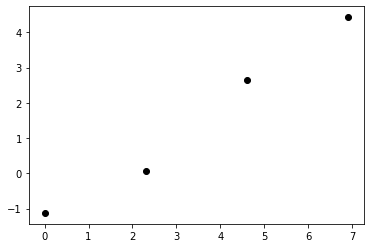

In [21]:
#Log log plot of error versus per mille enrichment sample versus std
x = (1, 10, 100, 1000)
y = (0.3212179600604015,1.0716007856963352, 13.941713054047739,84.8116186389343)
plt.scatter(np.log(x),np.log(y), color="black")
plt.savefig("/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/drafts/figures/sampleStandard.svg", format="svg")
plt.show()

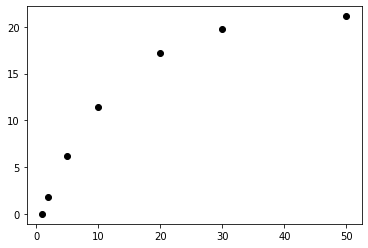

In [ ]:
#Error versus Concentration difference in sample and standard (to test importance of concentration matching)
x = (1, 2, 5, 10, 20, 30, 50)
y = (0.3212179600604015,0.4264584198905711,0.49936772537570223,0.5244358355521229,0.5365140188759234, 0.5403934259200639, 0.5435057933336671)
plt.scatter(x,y, color="black")
plt.savefig("/Users/sarahzeichner/Documents/Caltech/Research/Direct Injection/drafts/figures/concentrationVariation.svg", format="svg")
plt.show()